# Crop Type Classification: CART L8 and PS

This notebook is a continuation of [Crop Type Classification: CART
](classify-cart.ipynb) in which we use Landsat 8 as well as the PS Orthotile to generate features for CART classification.

This notebook demonstrates the following:
1. Finding a Landsat 8 scene that overlaps a PS Orthotile
1. Resampling Landsat 8 bands to match a PS Orthotile
1. Loading, visualizing, and using bitwise logic to convert a Landsat 8 QA band to a mask
1. Training a CART classifier using a combination of features from the PS Orthotile and Landsat 8 scene
1. Quantifying the performance of the classifier on the training data (upper limit of performance on a new dataset)

To enable this notebook, a lot of functionality was copied from [Crop Type Classification: CART
](classify-cart.ipynb).

This notebook only utilizes the train dataset and tests the classifier results on the train dataset again. Future improvements would include testing on the train dataset.


## Install Dependencies

In [6]:
from collections import namedtuple, OrderedDict
import json
import os
import pathlib
from subprocess import check_output, STDOUT, CalledProcessError
import tempfile
from xml.dom import minidom

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Identify Datasets

### PS Orthotile

Identify and, if necessary, download files associated with PS Orthotile [210879_1558814_2016-07-25_0e16](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/210879_1558814_2016-07-25_0e16/thumb).

In [7]:
train_scene_id = '210879_1558814_2016-07-25_0e16'

In [8]:
# define and, if necessary, create cart data directory
train_folder = os.path.join('data', 'cart', '210879_1558814_2016-07-25_0e16')
pathlib.Path(train_folder).mkdir(parents=True, exist_ok=True)

# define data file filenames and ensure they exist
train_files = {
    'scene': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif'),
    'metadata': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml'),
    'udm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif'),
}

In [9]:
# First test if scene file exists, if not, use the Planet commandline tool to download the image, metadata, and udm.
# This command assumes a bash shell, available in Unix-based operating systems.
train_scene = train_files['scene']
!test -f $train_scene || \
    planet data download \
        --item-type PSOrthoTile \
        --dest $train_folder \
        --asset-type analytic,analytic_xml,udm \
        --string-in id $train_scene_id

In [10]:
for filename in train_files.values():
    print(filename)
    assert os.path.isfile(filename)

data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif


In [28]:
# define data file filenames and ensure they exist
train_folder = os.path.join('data', 'cart', '210879_1558814_2016-07-25_0e16')
print(train_folder)

train_files = {
    'scene': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif'),
    'metadata': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml'),
    'udm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif'),
}

for filename in train_files.values():
    print(filename)
    assert os.path.isfile(filename)

data/cart/210879_1558814_2016-07-25_0e16
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif
data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml


#### Identify Gold Dataset

The CDL image is used as the gold dataset. The train CDL image is prepared in the `datasets-prepare-cdl` notebook.

In [11]:
predata_folder = 'pre-data'

In [12]:
train_CDL_filename = os.path.join(predata_folder, 'CDL_2016_19_train.tif')
assert os.path.isfile(train_CDL_filename)
train_files['gold'] = train_CDL_filename

### Landsat 8 Scene

To find the Landsat 8 scene that corresponds to the PS Orthotile, we read the Orthotile footprint from the Orthotile metadata and save it as geojson for use in searching for Landsat 8 scenes in Planet Explorer. 

In [13]:
# save Orthotile footprint as aoi geojson

def get_footprint_coords(metadata_filename):
    xmldoc = minidom.parse(metadata_filename)
    fp_node = xmldoc.getElementsByTagName('ps:Footprint')[0]

    # hone in on the footprint coordinates
    # the coordinates are always specified in WGS84, which is also the
    # geographic coordeinate system
    coords_node = fp_node.getElementsByTagName('gml:coordinates')[0]
    coords_str = coords_node.firstChild.data
    
    # coordinates entry is space-separated lat,lon
    coords = [[float(c) for c in cs.split(',')] for cs in coords_str.split(' ')]
    return coords

def coords_to_feature(coords):
    geom = {
        "type": "Polygon",
        "coordinates": [coords]
        }
    
    feature = {
        "type": "Feature",
        "properties": {},
        "geometry": geom}

    return feature
        
def write_geojson(feature, filename):
    with open(filename, "w") as f:
        f.write(json.dumps(feature))
    
    print(filename)
        
coords = get_footprint_coords(train_files['metadata'])
feat = coords_to_feature(coords)
print(json.dumps(feat))

# save aoi and add to list of files
aoi_filename = os.path.join(train_folder, 'aoi.geojson')
write_geojson(feat, aoi_filename)
train_files['aoi'] = aoi_filename

{"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-93.2991294841129, 42.6995987669915], [-93.2996742314127, 42.8127566482941], [-93.2884356831875, 42.8619208871588], [-93.2653319466575, 42.9248165306276], [-92.9938730936993, 42.9251238519476], [-92.9938880477425, 42.7736373428868], [-92.9983961055212, 42.7545290276869], [-93.0191535706845, 42.6999877495273], [-93.2991294841129, 42.6995987669915]]]}}
data/cart/210879_1558814_2016-07-25_0e16/aoi.geojson


#### Download Landsat Scene

In planet explorer, we upload the AOI as a filter geometry then filter the dates to July 1, 2016 to September 2, 2016. This query results in two Landsat 8 scenes, with [LC80260302016245LGN00](https://api.planet.com/data/v1/item-types/Landsat8L1G/items/LC80260302016245LGN00/thumb) standing out as the best scene to use.

In [15]:
landsat_scene_id = 'LC80260302016245LGN00'

In [17]:
# uncomment below to learn more about Landsat8L1G scene

# !planet data search --item-type Landsat8L1G --string-in id $landsat_scene_id

In [18]:
# define and, if necessary, create cart data directory
src_l8_folder = os.path.join('data', 'cart', 'LC80260302016245LGN00')
pathlib.Path(src_l8_folder).mkdir(parents=True, exist_ok=True)

In [20]:
# define landsat 8 bands
l8_filenames = {
    'qa': 'LC80260302016245LGN00_BQA.TIF',
    'b2': 'LC80260302016245LGN00_B2.TIF',
    'b3': 'LC80260302016245LGN00_B3.TIF',
    'b4': 'LC80260302016245LGN00_B4.TIF',
    'b5': 'LC80260302016245LGN00_B5.TIF',
#     'b6': 'LC80260302016245LGN00_B6.TIF',
#     'b7': 'LC80260302016245LGN00_B7.TIF'
}

def abs_path_filenames(folder, filenames):
    return dict([(k, os.path.join(folder, fn))
                 for k, fn in filenames.items()])

src_l8_files = abs_path_filenames(src_l8_folder, l8_filenames)
src_l8_files

{'b2': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B2.TIF',
 'b3': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B3.TIF',
 'b4': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B4.TIF',
 'b5': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B5.TIF',
 'qa': 'data/cart/LC80260302016245LGN00/LC80260302016245LGN00_BQA.TIF'}

In [29]:
# First test if scene file exists, if not, use the Planet commandline tool to download the image, metadata, and udm.
# This command assumes a bash shell, available in Unix-based operating systems.
landsat_qa = src_l8_files['qa']
!test -f $landsat_qa || \
    planet data download \
        --item-type Landsat8L1G \
        --dest $src_l8_folder \
        --asset-type analytic_bqa,analytic_b2,analytic_b3,analytic_b4,analytic_b5 \
        --string-in id $landsat_scene_id

In [30]:
for filename in src_l8_files.values():
    print(filename)
    assert os.path.isfile(filename)

data/cart/LC80260302016245LGN00/LC80260302016245LGN00_BQA.TIF
data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B2.TIF
data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B3.TIF
data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B4.TIF
data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B5.TIF


# Resample Landsat Scene to PS Orthotile

To stack the Landsat 8 and PS Orthothile bands, the pixels must be the same size and line up spatially. To accomplish this, we resample the Landsat 8 scene to the Orthotile.

In [31]:
# Utility functions: crop, resample, and project an image

# These use gdalwarp. for a description of gdalwarp command line options, see:
# http://www.gdal.org/gdalwarp.html

# projection is not required for our application, where the Landsat
# scene and the PS Orthotile are projected to the same UTM Zone
# but this code is kept here in case that changes
# def gdalwarp_project_options(src_crs, dst_crs):
#     return ['-s_srs', src_crs.to_string(), '-t_srs', dst_crs.to_string()]

def gdalwarp_crop_options(bounds, crs):
    xmin, ymin, xmax, ymax = [str(b) for b in bounds]
    # -te xmin ymin xmax ymax
    return ['-te', xmin, ymin, xmax, ymax]

def gdalwarp_resample_options(width, height, technique='near'):
    # for technique options, see: http://www.gdal.org/gdalwarp.html
    return ['-ts', width, height, '-r', technique]

def gdalwarp(input_filename, output_filename, options):
    commands = _gdalwarp_commands(input_filename, output_filename, options)

    # print error if one is encountered
    # https://stackoverflow.com/questions/29580663/save-error-message-of-subprocess-command
    try:
        output = check_output(commands, stderr=STDOUT)
    except CalledProcessError as exc:
        print(exc.output)

def _gdalwarp_commands(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    return commands

def _test():
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = src_l8_files['qa']

    with rasterio.open(TEST_DST_SCENE, 'r') as dst:
        with rasterio.open(TEST_SRC_SCENE, 'r') as src:
#             print(gdalwarp_project_options(src.crs, dst.crs))
            print(gdalwarp_crop_options(dst.bounds, dst.crs))
            print(gdalwarp_resample_options(dst.width, dst.height))
# _test()

In [32]:
def prepare_l8_band(band_filename, dst_filename, out_filename, classified=False):
    '''Project, crop, and resample landsat 8 band to match dst_filename image.'''
    
    # use 'near' resampling method for classified (e.g. qa) band,
    # otherwise use 'cubic' method
    method = 'near' if classified else 'cubic'
    
    with rasterio.open(band_filename, 'r') as src:
        with rasterio.open(dst_filename, 'r') as dst:
            # project
            # proj_options = gdalwarp_project_options(src_crs, dst.crs)

            # crop
            crop_options = gdalwarp_crop_options(dst.bounds, dst.crs)

            # resample
            width, height = dst.shape
            resample_options = gdalwarp_resample_options(str(width), str(height), method)

            options = crop_options + resample_options
            
            # run gdalwarp
            gdalwarp(band_filename, out_filename, options)


def _test(delete=True):
    TEST_DST_SCENE = train_files['scene']
    TEST_SRC_SCENE = src_l8_files['qa']
    
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=delete, dir='.') as out_file:
        # create output
        prepare_l8_band(TEST_SRC_SCENE, TEST_DST_SCENE, out_file.name, classified=True)

        # check output
        with rasterio.open(TEST_DST_SCENE, 'r') as dst:
            with rasterio.open(out_file.name, 'r') as src:
                assert dst.crs == src.crs, '{} != {}'.format(src.crs, dst.crs)
                assert dst.bounds == src.bounds
                assert dst.shape == src.shape
# _test()

In [36]:
def prepare_l8_bands(src_files, dst_folder, ps_scene):
    dst_files = {}
    for name, filename in src_l8_files.items():
        # qa band is the only classified band
        classified = name=='qa'
        
        dst_file = os.path.join(dst_folder, os.path.basename(filename))
        prepare_l8_band(filename, ps_scene, dst_file, classified=classified)
        dst_files[name] = dst_file
    return dst_files

def _test():
    try:
        out_folder = tempfile.mkdtemp()
        dst_l8_files = prepare_l8_bands(src_l8_files, out_folder, train_files['scene'])
        print(dst_l8_files)
    finally:
        del out_folder
# _test()

In [37]:
train_l8_folder = 'data/cart/210879_1558814_2016-07-25_0e16/L8'

if not os.path.isdir(train_l8_folder):
    os.mkdir(train_l8_folder)
    print(train_l8_folder)

In [38]:
train_l8_files = prepare_l8_bands(src_l8_files, train_l8_folder, train_files['scene'])
train_l8_files

gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r near -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_BQA.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_BQA.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B2.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B2.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B3.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B3.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC80260302016245LGN00_B4.TIF data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B4.TIF
gdalwarp -te 475500.0 4727500.0 500500.0 4752500.0 -ts 8000 8000 -r cubic -overwrite data/cart/LC80260302016245LGN00/LC8026

{'b2': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B2.TIF',
 'b3': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B3.TIF',
 'b4': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B4.TIF',
 'b5': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_B5.TIF',
 'qa': 'data/cart/210879_1558814_2016-07-25_0e16/L8/LC80260302016245LGN00_BQA.TIF'}

## Landsat 8 QA band

We use the Landsat 8 QA band to mask out any 'bad' (quality issue, cloud, etc) pixels. To accomplish this, first we create functionality for dealing with any generic classified band, then we load the QA band, visualize it, and convert it to a mask.

In [39]:
# Utility functions: visualizing a classified band as an image

def plot_image(image, title, figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    image.imshow(ax)
    ax.set_title(title)
    ax.set_axis_off()
        
class ClassifiedImage(object):
    def __init__(self, band, labels=None):
        self.band = band
        self.labels = labels

    def imshow(self, ax, cmap='rainbow'):
        """Show classified band with colormap normalization and color legend.
        
        Alters ax in place.

        possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
        """
        class_norm = _ClassNormalize(self.band)
        im = ax.imshow(self.band, cmap=cmap, norm=class_norm)

        try:
            # add class label legend
            # https://stackoverflow.com/questions/25482876
            # /how-to-add-legend-to-imshow-in-matplotlib
            color_mapping = class_norm.mapping
            colors = [im.cmap(color_mapping[k])
                      for k in self.labels.keys()]
            labels = self.labels.values()

            # https://matplotlib.org/users/legend_guide.html
            # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
            patches = [mpatches.Patch(color=c, label=l)
                       for c,l in zip(colors, labels)]

            ax.legend(handles=patches, bbox_to_anchor=(1, 1),
                      loc='upper right', borderaxespad=0.)
        except AttributeError:
            # labels not specified
            pass


# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    
    __init__ and __call__ are the minimum required methods.
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct)
                            for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        return self._mapping

def _test():
#     classified_band = np.array(range(4)).reshape((2,2))
    classified_band = np.array([0, 1, 2, 28, 30, 64, 66, 92, 94], dtype=np.uint8).reshape((3,3))
    print(classified_band)
    labels = OrderedDict((v, str(v)) for v in np.unique(classified_band))
    classified_image = ClassifiedImage(band=classified_band, labels=labels)
    plot_image(classified_image, title='Test', figsize=(4,4))
# _test()

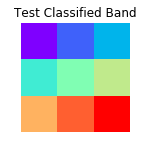

In [42]:
def plot_classified_band(class_band, class_labels=None, cmap='rainbow',
                         title='Class Labels', figdim=10):
    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend. Alters ax in place.
    
    possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k]) for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    
    Inspired by https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        # map unique values to points in the range 0-1
        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct) for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        '''Create classified representation of arry for display.'''
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        '''property required for colors.Normalize classes
        
        We update the _mapping property in __init__ and __call__ and just
        return that property here.
        '''
        return self._mapping
    
# test out classified band visualization
test_classified_band = np.array(range(9)).reshape((3,3))
plot_classified_band(test_classified_band, title='Test Classified Band', figdim=2)

Functionality specific to the QA Band

In [40]:
# Utility function for working with large images and memory limitations

def _read_window(filename, window):
    with rasterio.open(filename, 'r') as src:
        return src.read(window=window)

def decimated(arry, num=8):
    return arry[::num, ::num].copy()

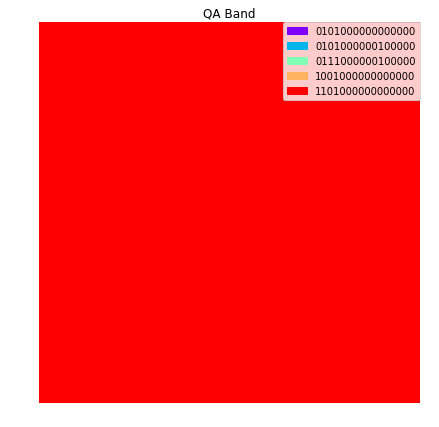

In [48]:
def load_band(band_filename, window=None):
    return _read_window(band_filename, window)[0,...]

def get_qa_labels(binary_band):
    return OrderedDict((v, '{0:b}'.format(v).zfill(16))
                       for v in np.unique(binary_band))

def _test():
    qa = decimated(load_band(train_l8_files['qa']), num=1)
    qa_labels = get_qa_labels(qa)
    qa_classified_band = ClassifiedImage(band=qa, labels=qa_labels)
#     plot_image(qa_classified_band, title='QA Band', figsize=(7,7))
    plot_classified_band(qa, class_labels=qa_labels, title='QA Band', figdim=7)
_test()

In [64]:
def qa_to_mask(qa_array):
    """Generate mask from L8 QA band.
    
    Pre-Collection:
    The description for the pre-collection QA band is no longer hosted by USGS.
    We pull it from plcompositor, information encoded in the bits in the QA is from:
    https://github.com/planetlabs/plcompositor/blob/master/src/landsat8cloudquality.cpp#L28
    
    For the single bits (0, 1, 2, and 3):
    0 = No, this condition does not exist
    1 = Yes, this condition exists.
    
    The double bits (4-5, 6-7, 8-9, 10-11, 12-13, and 14-15)
    represent levels of confidence that a condition exists:
    00 = Algorithm did not determine the status of this condition
    01 = Algorithm has low confidence that this condition exists 
         (0-33 percent confidence)
    10 = Algorithm has medium confidence that this condition exists 
         (34-66 percent confidence)
    11 = Algorithm has high confidence that this condition exists 
         (67-100 percent confidence).

     Mask    Meaning
    0x0001 - Designated Fill
    0x0002 - Dropped Frame
    0x0004 - Terrain Occlusion
    0x0008 - Reserved
    0x0030 - Water Confidence
    0x00c0 - Reserved for cloud shadow
    0x0300 - Vegitation confidence
    0x0c00 - Show/ice Confidence
    0x3000 - Cirrus Confidence
    0xc000 - Cloud Confidence
    
    Collection 1:
    
    The description for the information encoded in the bits in the QA is from:
    https://landsat.usgs.gov/collectionqualityband
    
    Bit 0: designated fill
    Bit 1: terrain occlusion
    Bits 2/3: radiometric saturation
    Bit 4: cloud
    Bits 5/6: cloud confidence
    Bits 7/8: cloud shadow confidence
    Bits 9/10: snow/ice confidence
    Bits 11/12: cirr
    """
    # check for absolute or >= med confidence of any condition
    test_bits = int('1010101000001111',2)
    bit_matches = qa_array & test_bits # bit-wise logical AND operator
    return bit_matches != 0 # mask any pixels that match test bits

def _test():
    mask = qa_to_mask(load_band(train_l8_files['qa']))
    print('{}/{} ({:0.1f}%) masked'.format(mask.sum(), mask.size,
                                           (100.0 * mask.sum())/mask.size))
_test()

266089/64000000 (0.4%) masked


Only 0.4% masked bodes well for the usefulness of this Landsat 8 scene!

## Landsat 8 and PS Orthotile Visual Images

Before we jump into training the classifier, we want to visualize the Landsat 8 and PS Orthotile RGB images to get a feel for what they show.

To do this, we first create classes that load and store the PS and L8 analytic images, (PSImage and L8Image, respectively). We then create a class that displays an RGB image, taking care of the necessary scaling and masking. We then use these classes to visualize the PS and L8 RGB images.

### PS Orthotile Visual Image

#### Mask from UDM

14525797/64000000 (23%) masked


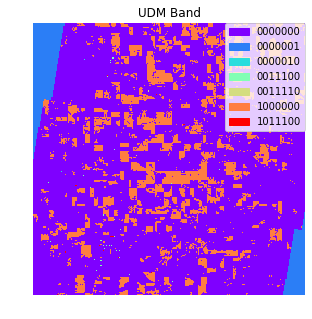

In [65]:
def get_udm_labels(binary_band):
    return OrderedDict((v, '{0:b}'.format(v).zfill(7))
                       for v in np.unique(binary_band))

def udm_to_mask(udm_array):
    '''Create a mask from the udm.
    
    The description for the information encoded in the bits in the UDM is from:
    https://www.planet.com/docs/spec-sheets/sat-imagery/
    section 7.2
    
    Bit 0: blackfill
    Bit 1: cloud covered
    Bit 2: missing or suspect data in Blue band
    Bit 3: missing or suspect data in Green band
    Bit 4: missing or suspect data in Red band
    Bit 6: missing or suspect data in NIR band

    Pixels with no issues have all bits set to 0, therefore their values are zero.    
    ''' 
    return udm_array != 0

def _test():
    udm = load_band(train_files['udm'])
    mask = udm_to_mask(udm)
    print('{}/{} ({:0.0f}%) masked'.format(mask.sum(), mask.size,
                                          (100.0 * mask.sum())/mask.size))

    udm_dec = decimated(udm, 32)
    udm_labels = get_udm_labels(udm_dec)
    udm_image = ClassifiedImage(band=udm_dec, labels=udm_labels)
    plot_image(udm_image, title='UDM Band', figsize=(5,5))
_test()

#### Visual RGB

Create a few classes that store the analytic and visual images, to simplify processing and visualizing the PS Orthotile image.

In [66]:
PSBands = namedtuple('PSBands', 'b, g, r, nir')

class PSImage(object):    
    def __init__(self, scene_filename, udm_filename, window=None):
        self.scene_filename = scene_filename
        self.udm_filename = udm_filename
        self.window = window

        self._bands = self._load_bands()
        
    def _load_bands(self):
        """Loads a 4-band BGRNir Planet Image file as a list of masked bands.

        The masked bands share the same mask, so editing one band mask will
        edit them all.
        """
        with rasterio.open(self.scene_filename, 'r') as src:
            b, g, r, nir = src.read(window=self.window)
            bands = PSBands(b=b, g=g, r=r, nir=nir)

        with rasterio.open(self.udm_filename, 'r') as src:
            udm = src.read(window=self.window)[0,...]

        mask = udm_to_mask(udm)
        return PSBands(*[np.ma.array(b, mask=mask) for b in bands])

    def rgb_bands(self):
        return [self._bands.r, self._bands.g, self._bands.b]
        
    @property
    def mask(self):
        return self._bands[0].mask
    
    @property
    def bands(self):
        return self._bands


def check_mask(img):
    band_mask = img.mask
    return '{}/{} ({:0.0f}%) masked'.format(band_mask.sum(), band_mask.size,
                                            (100.0 * band_mask.sum())/band_mask.size)

def _test():
    window = ((500,1500),(500,1500))
    print(check_mask(PSImage(train_files['scene'], train_files['udm'], window=window)))

    window = None
    print(check_mask(PSImage(train_files['scene'], train_files['udm'], window=window)))
# _test()

In [67]:
# Utility functions: displaying an rgb image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))


class RGBImage(object):
    def __init__(self, bands):
        # bands: list of masked bands in RGB order
        # masked bands should share the same mask
        assert len(bands) == 3
        self.bands = bands

    def imshow(self, ax, alpha=True):
        """Show RGB image with option of convering mask to alpha.
        
        Alters ax in place.

        """
        ax.imshow(self.bands_to_display(alpha=alpha))
        

    def _mask_to_alpha(self):
        band = np.atleast_3d(self.bands[0])
        alpha = np.zeros_like(band)
        alpha[~band.mask] = 1
        return alpha

    def _percentile(self, percentile):
        return np.percentile(np.concatenate([b.compressed() for b in self.bands]),
                             percentile)

    def bands_to_display(self, alpha=False):
        """Converts bands to a normalized, 3-band 3d numpy array for display."""  

        old_min = self._percentile(2)
        old_max = self._percentile(98)
        new_min = 0
        new_max = 1
        scaled = [np.clip(_linear_scale(b.astype(np.float),
                                        old_min, old_max,
                                        new_min, new_max),
                          new_min, new_max)
                  for b in self.bands]

        filled = [b.filled(fill_value=new_min) for b in scaled]

        if alpha:
            filled.append(self._mask_to_alpha())

        return np.dstack(filled)

def _test():
    img = PSImage(train_files['scene'], train_files['udm'], window=None)
    rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    plot_image(rgb_image, title='PS RGB', figsize=(6,6))
# _test()

### Landsat 8 Visual Image

Create a class that stores the analytic Landsat 8 image.

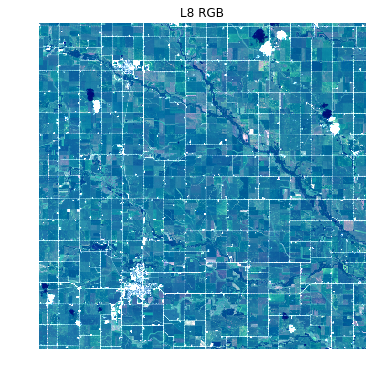

In [68]:
L8Bands = namedtuple('L8Bands', 'b2, b3, b4, b5')
        
class L8Image(object):
    def __init__(self, band_filenames, qa_filename, window=None):
        self.band_filenames = band_filenames
        self.qa_filename = qa_filename
        self.window = window

        self._bands = self._load_bands()
    
    def _load_mask(self):
        qa = self._read_band(self.qa_filename)
        return qa_to_mask(qa)
        
    def _load_bands(self):
        def _try_read_band(band_name, mask):
            try:
                filename = self.band_filenames[band_name]
                band_arry = self._read_band(filename)
                band = np.ma.array(band_arry, mask=mask)
            except KeyError:
                # band_name not a key in band_filenames
                band = None
            return band

        mask = self._load_mask()
        return L8Bands(*[_try_read_band(band_name, mask)
                         for band_name in L8Bands._fields])
    
    def _read_band(self, filename):
        with rasterio.open(filename, 'r') as src:
            band = src.read(window=self.window)[0,...]
        return band
    
    def rgb_bands(self):
        rgb_bands = [self._bands.b4, self._bands.b3, self._bands.b2]
        return rgb_bands

    @property
    def mask(self):
        return self._bands[0].mask
    
    @property
    def bands(self):
        return self._bands

def _test():
    img = L8Image(train_l8_files, train_l8_files['qa'], window=None)
    rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    plot_image(rgb_image, title='L8 RGB', figsize=(6,6))
_test()

### Visual Comparison

Load the PS Orthotile and Landsat 8 images, then compare the visual RGB representation of those images.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


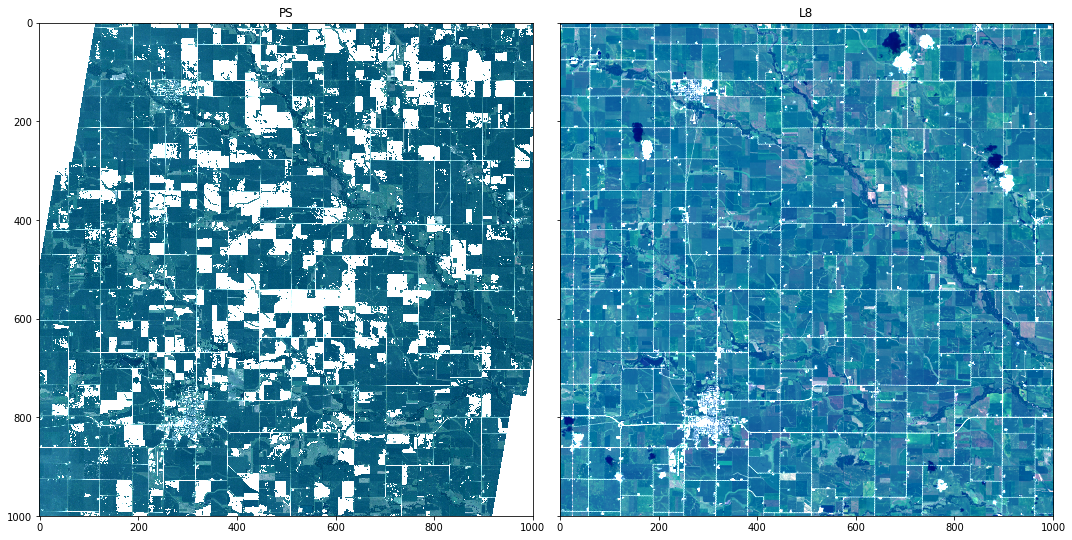

In [69]:
def plot_rgb_comparison(ps_files, l8_files, figsize=(15,15)):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')

    # PS
    img = PSImage(ps_files['scene'], ps_files['udm'], window=None)
    ps_rgb_image = RGBImage([decimated(b) for b in img.rgb_bands()])
    ps_rgb_image.imshow(ax1)
    ax1.set_title('PS')

    # L8
    rgb_bandnames = ['b4', 'b3', 'b2']
    rgb_files = dict([(k, l8_files[k]) for k in rgb_bandnames])
    l8_img = L8Image(rgb_files, l8_files['qa'], window=None)
    l8_rgb_image = RGBImage([decimated(b) for b in l8_img.rgb_bands()])
    l8_rgb_image.imshow(ax2)
    ax2.set_title('L8')

    plt.tight_layout()

plot_rgb_comparison(train_files, train_l8_files)

## Features from Images

To classify the image, we first create 'feature bands', which are bands that hold each of the classification features, from the L8 and PS analytic images. An important step to creating the feature bands is ensuring that any pixel that is masked in either image is masked in the feature bands.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


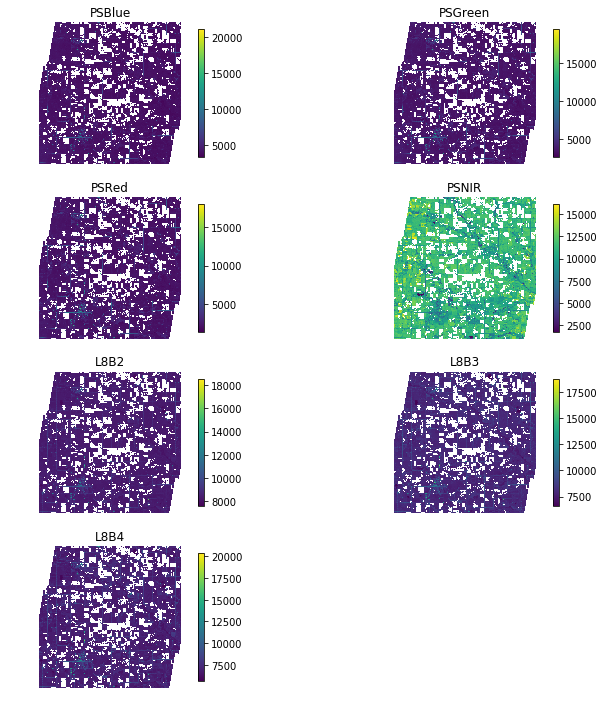

In [70]:
def build_feature_bands(ps_img, l8_img):
    """Prepare bands representing pixel features and provide feature names.
    
    Takes as input NamedBands
    Returns (1) tuple of bands representing features and (2) feature names
    """  
    # not copying these bands to minimize memory footprints
    features = (ps_img.bands.b, ps_img.bands.g, ps_img.bands.r, ps_img.bands.nir,
                l8_img.bands.b2, l8_img.bands.b3, l8_img.bands.b4, l8_img.bands.b5)
    
    new_mask = ps_img.mask | l8_img.mask
    for band in features:
        band.mask = new_mask

    feature_names = ('PSBlue', 'PSGreen', 'PSRed', 'PSNIR',
                     'L8B2', 'L8B3', 'L8B4', 'L8B5')
    return features, feature_names


def display_feature_bands(bands, names):
    # for this notebook, we know there are 8 features and we will use that
    # knowledge to side-step some logic in organizing subplots
    assert len(bands) == 8 
    
    fig, subplot_axes = plt.subplots(nrows=4, ncols=2,
                                     sharex=True, sharey=True,
                                     figsize=(10,10))
    axes = subplot_axes.flat[:-1]
    delaxis = subplot_axes.flat[-1]
    fig.delaxes(delaxis)
    for ax, band, name in zip(axes, bands, names):
        ax.set_adjustable('box-forced')
        ax.axis('off')

        pcm = ax.imshow(band, alpha=True)
        ax.set_title(name)
        fig.colorbar(pcm, ax=ax,
                     pad=0.05, shrink=0.9)

    plt.tight_layout()

def _test():
#     window = ((500,1500),(500,1500))
    window = None

    ps_img = PSImage(train_files['scene'], train_files['udm'], window=window)
    l8_img = L8Image(train_l8_files, train_l8_files['qa'], window=window)
    feat_bands, feat_names = build_feature_bands(ps_img, l8_img)
    display_feature_bands(feat_bands, feat_names)
_test()

## Classify Image

In this section, we load the labels and train the classifier using the feature bands, then run the prediction on the train feature bands to see how well the features differentiate the classes.

In [71]:
# copied from classify-cart.ipynb

CLASS_LABELS = {1: 'corn', 5: 'soybeans'}

def load_gold_class_band(gold_filename, class_labels=None, window=None, fill_value=0):
    gold_class_band = _read_window(gold_filename, window)[0,...]
    
    try:
        # mask pixels with a value not in class_labels
        masks = [gold_class_band == val for val in class_labels.keys()]
        mask = np.any(np.dstack(masks), axis=2)
        mask = ~mask
        
        masked_band = np.ma.array(np.ma.array(gold_class_band, mask=mask)\
                                      .filled(fill_value=fill_value),
                                  mask=mask)
    except AttributeError:
        # mask nothing
        null_mask = np.zeros(gold_class_band.shape, dtype=np.bool)
        masked_band = np.ma.array(gold_class_band, mask=null_mask)

    return masked_band

def _test():
    labels = CLASS_LABELS
    gold_band = load_gold_class_band(train_files['gold'], class_labels=labels)

    gold_dec = decimated(gold_band)
    gold_image = ClassifiedImage(band=gold_dec, labels=labels)
    plot_image(gold_image, title='Gold Band', figsize=(5,5))
# _test()

### Train Classifier

In [72]:
# copied from classify-cart.ipynb
def to_X(feature_bands):
    """Convert feature_bands (tuple of bands) to 2d array for working with classifier.
    """
    return np.stack([f.compressed() for f in feature_bands], # exclude masked pixels
                     axis=1)

def to_y(classified_band):
    return classified_band.compressed()

def classified_band_from_y(y, band_mask):
    class_band = np.ma.array(np.zeros(band_mask.shape),
                             mask=band_mask.copy())
    class_band[~class_band.mask] = y
    return class_band

In [73]:
window = None

In [74]:
# Prepare features
ps_img = PSImage(train_files['scene'],
                 train_files['udm'],
                 window=window)
l8_img = L8Image(train_l8_files,
                 train_l8_files['qa'],
                 window=window)
feat_bands, _ = build_feature_bands(ps_img, l8_img)
X = to_X(feat_bands)
print(X.shape)

(49273735, 8)


In [75]:
# Prepare labels
labels = CLASS_LABELS
gold_band = load_gold_class_band(train_files['gold'],
                                 class_labels=labels,
                                 window=window)
gold_band.mask = feat_bands[0].mask #get_mask(feat_bands)
y = to_y(gold_band)
print(y.shape)

(49273735,)


In [83]:
import pickle

### Train classifier on PS + L8 features

By default, the classifier is loaded from the cache to speed up processing

In [88]:
clf_cache_file = os.path.join('pre-data', 'classify-cart-l8-clf.sav')

load_clf = True
if load_clf:
    assert os.path.isfile(clf_cache_file)
    assert X.shape == (49273735, 8)
    assert y.shape == (49273735,)
    clf = pickle.load(open(clf_cache_file, 'rb'))
else:
    clf = DecisionTreeClassifier(random_state=0, max_depth=5)
    clf.fit(X, y)   

In [89]:
# optionally save clf model
save_clf = False
if save_clf:
    pickle.dump(clf, open(clf_cache_file, 'wb'))

### Run Prediction on Train Features

In [91]:
# Run prediction on train features
y_pred = clf.predict(X)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


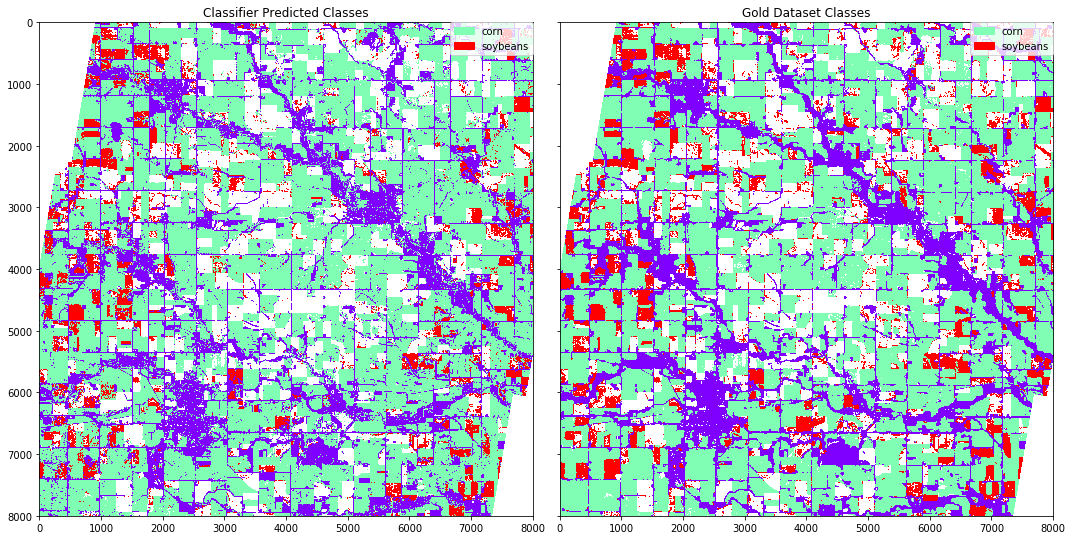

In [92]:
# Display classification results
def plot_predicted_vs_truth(predicted_class_band, gold_class_band,
                            class_labels=None, figsize=(15,15)):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')
    
    pred_img = ClassifiedImage(band=predicted_class_band, labels=CLASS_LABELS)
    pred_img.imshow(ax1)
    ax1.set_title('Classifier Predicted Classes')

    gold_img = ClassifiedImage(band=gold_class_band, labels=CLASS_LABELS)
    gold_img.imshow(ax2)
    ax2.set_title('Gold Dataset Classes')
    plt.tight_layout()

pred_band = classified_band_from_y(y_pred, feat_bands[0].mask)
plot_predicted_vs_truth(pred_band, gold_band, class_labels=CLASS_LABELS)

### Quantify Performance on Train Features

Quantify the performance on the train features, which represents the upper limit for classification accuracy when a prediction is run on a new image.

In [93]:
print(classification_report(y,
                            y_pred,
                            target_names=['neither', 'corn', 'soybean']))

              precision    recall  f1-score   support

     neither       0.75      0.77      0.76  12724691
        corn       0.88      0.92      0.90  30948753
     soybean       0.86      0.63      0.73   5600291

   micro avg       0.85      0.85      0.85  49273735
   macro avg       0.83      0.77      0.80  49273735
weighted avg       0.85      0.85      0.84  49273735



The classifier performance for classifying a pixel as neither, corn, or soybean, calculated on the train features, is an f1-score of 0.84.

# Compare PS to PS + L8

How does the accuracy of classification using PS + L8 compare to the accuracy using just PS?

In [107]:
def build_ps_feature_bands(ps_img):
    # not copying these bands to minimize memory footprints
    features = (ps_img.bands.b, ps_img.bands.g, ps_img.bands.r, ps_img.bands.nir)
    feature_names = ('PSBlue', 'PSGreen', 'PSRed', 'PSNIR')
    return features, feature_names

ps_feature_bands = (ps_img.bands.b, ps_img.bands.g, ps_img.bands.r, ps_img.bands.nir)
ps_X = to_X(ps_feature_bands)

### Train classifier on PS features

By default, the classifier is loaded from the cache to speed up processing

In [108]:
ps_clf_cache_file = os.path.join('pre-data', 'classify-cart-l8-ps-clf.sav')

load_ps_clf = True
if load_ps_clf:
    assert os.path.isfile(ps_clf_cache_file)
    assert ps_X.shape == (49273735, 4)
    assert y.shape == (49273735,)
    ps_clf = pickle.load(open(ps_clf_cache_file, 'rb'))
else:
    ps_clf = DecisionTreeClassifier(random_state=0, max_depth=5)
    ps_clf.fit(ps_X, y)   

In [109]:
# optionally save ps clf model
save_ps_clf = False
if save_ps_clf:
    pickle.dump(ps_clf, open(ps_clf_cache_file, 'wb'))

In [110]:
# Run prediction on train features
ps_y_pred = ps_clf.predict(ps_X)

In [111]:
print(classification_report(y,
                            ps_y_pred,
                            target_names=['neither', 'corn', 'soybean']))

              precision    recall  f1-score   support

     neither       0.75      0.74      0.74  12724691
        corn       0.83      0.93      0.88  30948753
     soybean       0.90      0.35      0.51   5600291

   micro avg       0.81      0.81      0.81  49273735
   macro avg       0.83      0.67      0.71  49273735
weighted avg       0.82      0.81      0.80  49273735



The classifier performance for classifying a pixel as neither, corn, or soybean, calculated on the train features using just PS data, is an f1-score of 0.80, down from 0.84 when using PS and L8 data together.